# Oklahoma County Property Analysis

In [388]:
# Install required libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats

## Import CSV file

In [389]:
# Read the CSV file into a DataFrame
df = pd.read_csv('output.csv')

# Convert string representations of Python dictionaries back into the correct data type
df['market_values'] = df['market_values'].apply(ast.literal_eval)
df['sales_prices'] = df['sales_prices'].apply(ast.literal_eval)


## Clean Data and Add Columns

In [390]:
# Extract the most recent sales price and market value
get_most_recent = lambda x: next(iter(x.values())) if x else None
df['most_recent_sales_price'] = df['sales_prices'].apply(get_most_recent)
df['most_recent_market_value'] = df['market_values'].apply(get_most_recent)

# Calculate price/square foot
df['price/square_foot'] = df['most_recent_sales_price'] / df['square_feet']

# Calculate value change
df['value_change'] = df['most_recent_market_value'] - df['most_recent_sales_price']

# Create column of binary value based on if the house has a garage
df['has_garage'] = df['garage_sqft'].apply(lambda x: 1 if x > 0 else 0)

# Create column of binary value based on if the house has a garage apartment
df['has_apt'] = df['garage_apt_sqft'].apply(lambda x: 1 if x > 0 else 0)

# Display the DataFrame
df


,address,square_feet,market_values,sales_prices,year_built,bedrooms,bathrooms,garage_sqft,garage_apt_sqft,porch_sqft,unfin_attic_sqft,most_recent_sales_price,most_recent_market_value,price/square_foot,value_change,has_garage,has_apt
0,1000 PEDALERS LN,1024.0,"{2023: 331500, 2022: 284500, 2021: 243000, 202...",{2019: 232500},2018,3.0,1.5,0,0,71,0,232500.0,331500.0,227.050781,99000.0,0,0
1,1001 PEDALERS LN,1167.0,"{2023: 369000, 2022: 317000, 2021: 267500, 202...",{2019: 246000},2018,3.0,1.5,0,0,69,0,246000.0,369000.0,210.796915,123000.0,0,0
2,1004 PEDALERS LN,766.0,"{2023: 281500, 2022: 242000, 2021: 210500, 202...","{2020: 215000, 2019: 197500}",2018,2.0,1.5,0,0,56,0,215000.0,281500.0,280.678851,66500.0,0,0
3,1005 PEDALERS LN,756.0,"{2023: 277500, 2022: 237500, 2021: 208000, 202...",{2019: 191000},2018,1.0,1.0,0,0,102,0,191000.0,277500.0,252.645503,86500.0,0,0
4,1008 PEDALERS LN,1164.0,"{2023: 353500, 2022: 303000, 2021: 259500, 202...",{2019: 248500},2018,3.0,1.5,0,0,72,0,248500.0,353500.0,213.487973,105000.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1821 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},2020,3.0,3.0,448,0,198,0,429000.0,484000.0,279.478827,55000.0,1,0
161,1825 WHEELER ST,1498.0,"{2023: 430000, 2022: 430000}",{2021: 434000},2020,3.0,2.5,448,0,198,0,434000.0,430000.0,289.719626,-4000.0,1,0
162,1829 WHEELER ST,1496.0,"{2023: 474000, 2022: 410000}",{2021: 429000},2020,3.0,2.5,448,0,198,0,429000.0,474000.0,286.764706,45000.0,1,0
163,1833 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},2020,3.0,3.0,448,0,198,0,429000.0,484000.0,279.478827,55000.0,1,0


# Remove Outliers from the Datafame

In [391]:
# Define a function to remove outliers using the IQR method
def remove_outliers_iqr(data, column, multiplier=2.0):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Find the outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    # Remove outliers from the DataFrame
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data, outliers

# Define a function to remove outliers using the Z-score method
def remove_outliers_z_score(data, column, threshold=2):
    z_scores = stats.zscore(data[column])
    abs_z_scores = np.abs(z_scores)

    # Find the outliers
    outliers = data[abs_z_scores > threshold]

    # Remove outliers from the DataFrame
    filtered_data = data[abs_z_scores <= threshold]
    return filtered_data, outliers

# Specify the columns for which you want to remove outliers
columns_to_filter = ['square_feet', 'most_recent_market_value']

# Remove outliers from the specified columns
copy_df = df.copy()
filtered_df = copy_df.dropna(subset=['square_feet', 'most_recent_market_value'])
outliers_df = pd.DataFrame(columns=df.columns)

# Choose the method: 'iqr' or 'z_score'
method = 'iqr'

for column in columns_to_filter:
    if method == 'iqr':
        filtered_df, outliers = remove_outliers_iqr(filtered_df, column)
    elif method == 'z_score':
        filtered_df, outliers = remove_outliers_z_score(filtered_df, column)

    # Append the outliers for the current column to the outliers_df DataFrame
    outliers_df = outliers_df.append(outliers, ignore_index=True)

    # Print the outliers for the current column
    print(f"Outliers for {column}:")
    print(outliers)

# Check the shape of the filtered DataFrame
print("Original DataFrame shape:", df.shape)
print("Filtered DataFrame shape:", filtered_df.shape)

filtered_df

Outliers for square_feet:
Empty DataFrame
Columns: [address, square_feet, market_values, sales_prices, year_built, bedrooms, bathrooms, garage_sqft, garage_apt_sqft, porch_sqft, unfin_attic_sqft, most_recent_sales_price, most_recent_market_value, price/square_foot, value_change, has_garage, has_apt]
Index: []
Outliers for most_recent_market_value:
Empty DataFrame
Columns: [address, square_feet, market_values, sales_prices, year_built, bedrooms, bathrooms, garage_sqft, garage_apt_sqft, porch_sqft, unfin_attic_sqft, most_recent_sales_price, most_recent_market_value, price/square_foot, value_change, has_garage, has_apt]
Index: []
Original DataFrame shape: (165, 17)
Filtered DataFrame shape: (129, 17)


/var/folders/ys/99fy7jvd78ldkj5yxhg35plh0000gn/T/ipykernel_96643/3812303857.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers_df = outliers_df.append(outliers, ignore_index=True)
/var/folders/ys/99fy7jvd78ldkj5yxhg35plh0000gn/T/ipykernel_96643/3812303857.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers_df = outliers_df.append(outliers, ignore_index=True)


,address,square_feet,market_values,sales_prices,year_built,bedrooms,bathrooms,garage_sqft,garage_apt_sqft,porch_sqft,unfin_attic_sqft,most_recent_sales_price,most_recent_market_value,price/square_foot,value_change,has_garage,has_apt
0,1000 PEDALERS LN,1024.0,"{2023: 331500, 2022: 284500, 2021: 243000, 202...",{2019: 232500},2018,3.0,1.5,0,0,71,0,232500.0,331500.0,227.050781,99000.0,0,0
1,1001 PEDALERS LN,1167.0,"{2023: 369000, 2022: 317000, 2021: 267500, 202...",{2019: 246000},2018,3.0,1.5,0,0,69,0,246000.0,369000.0,210.796915,123000.0,0,0
2,1004 PEDALERS LN,766.0,"{2023: 281500, 2022: 242000, 2021: 210500, 202...","{2020: 215000, 2019: 197500}",2018,2.0,1.5,0,0,56,0,215000.0,281500.0,280.678851,66500.0,0,0
3,1005 PEDALERS LN,756.0,"{2023: 277500, 2022: 237500, 2021: 208000, 202...",{2019: 191000},2018,1.0,1.0,0,0,102,0,191000.0,277500.0,252.645503,86500.0,0,0
4,1008 PEDALERS LN,1164.0,"{2023: 353500, 2022: 303000, 2021: 259500, 202...",{2019: 248500},2018,3.0,1.5,0,0,72,0,248500.0,353500.0,213.487973,105000.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1821 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},2020,3.0,3.0,448,0,198,0,429000.0,484000.0,279.478827,55000.0,1,0
161,1825 WHEELER ST,1498.0,"{2023: 430000, 2022: 430000}",{2021: 434000},2020,3.0,2.5,448,0,198,0,434000.0,430000.0,289.719626,-4000.0,1,0
162,1829 WHEELER ST,1496.0,"{2023: 474000, 2022: 410000}",{2021: 429000},2020,3.0,2.5,448,0,198,0,429000.0,474000.0,286.764706,45000.0,1,0
163,1833 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},2020,3.0,3.0,448,0,198,0,429000.0,484000.0,279.478827,55000.0,1,0


# Test different types of Linear Regression models

Linear Regression:
Mean Squared Error: 4314059944.217855
R2 Score: 0.8278032407538264

Ridge Regression:
Mean Squared Error: 4236036282.2988296
R2 Score: 0.8320711863087729

Lasso Regression:
Mean Squared Error: 4314054367.653587
R2 Score: 0.8278034926374236

ElasticNet Regression:
Mean Squared Error: 4335569008.181735
R2 Score: 0.8321104869993567


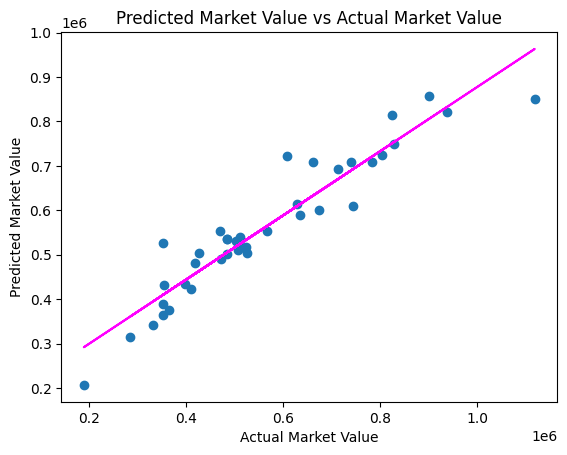

Predicted Market Value:  $564,792


In [392]:
# Remove NaN values from the specified columns
copy_df = df.copy()
filtered_df = copy_df.dropna(subset=['square_feet', 'most_recent_market_value'])
X = filtered_df[['square_feet', 'year_built', 'bedrooms', 'bathrooms', 'has_garage', 'has_apt']].values
y = filtered_df['most_recent_market_value'].values

# Break out training and testing portions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a function to evaluate different models
def evaluate_model(model, X, y):
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

    print(f'Mean Squared Error: {np.mean(mse_scores)}')
    print(f'R2 Score: {np.mean(r2_scores)}')

# Identify the numerical and categorical columns
numerical_columns = [0, 1, 2, 3]  # Indices for the numerical columns in X
binary_columns = [4, 5]  # Indices for the binary columns in X

# Define transformers for preprocessing
numerical_transformer = StandardScaler()  # You can also use MinMaxScaler()
binary_transformer = 'passthrough'

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('binary', binary_transformer, binary_columns)
    ])

# Linear Regression
model1 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', LinearRegression())])
print("Linear Regression:")
evaluate_model(model1, X, y)

# Ridge Regression
model2 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', Ridge(alpha=1.0))])
print("\nRidge Regression:")
evaluate_model(model2, X, y)

# Lasso Regression
model3 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', Lasso(alpha=0.1))])
print("\nLasso Regression:")
evaluate_model(model3, X, y)

# ElasticNet Regression
model4 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))])
print("\nElasticNet Regression:")
evaluate_model(model4, X, y)

market_model = model4.fit(X_train, y_train)
predictions = market_model.predict(X_test)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Market Value')
plt.ylabel('Predicted Market Value')
plt.title('Predicted Market Value vs Actual Market Value')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

# Predict market value
predicted_market_value = market_model.predict([[1700, 2021, 3, 3, 1, 0]])[0]
formatted_market_value = "${:,.0f}".format(predicted_market_value)
print("Predicted Market Value: ", formatted_market_value)


## Market Value Linear Regression

MSE: 4122345849.701765
RMSE: 64205.49703648251
R2: 0.8845029296029104


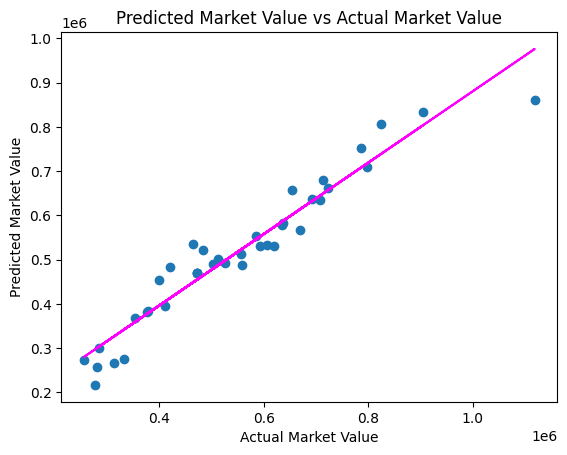

In [393]:
# Clean the data and break into features and labels
cleaned_df = df.dropna(subset=['square_feet', 'most_recent_market_value'])
X = cleaned_df[['square_feet', 'year_built', 'bedrooms', 'bathrooms', 'has_garage', 'has_apt']].values
y = cleaned_df['most_recent_market_value'].values

# Split data into training/testing groups and create a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
market_model = LinearRegression().fit(X_train, y_train)
predictions = market_model.predict(X_test)

# Determine how well the model predicts
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Market Value')
plt.ylabel('Predicted Market Value')
plt.title('Predicted Market Value vs Actual Market Value')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Try a Lasso Model on the Market Value

Best alpha value: 1.0
MSE: 4122197475.7547035
RMSE: 64204.341564684735
R2: 0.8845070866428177


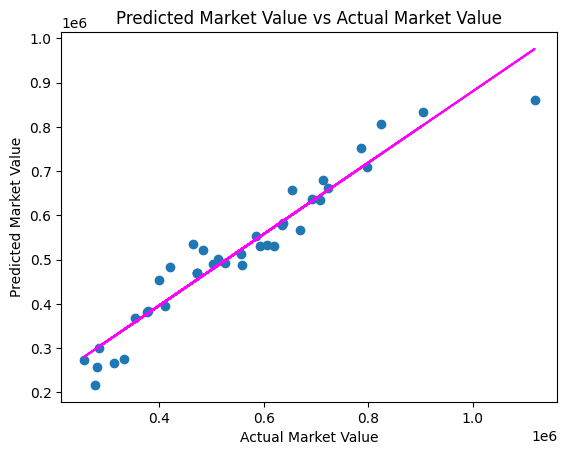

In [394]:
# Clean the data and break into features and labels
cleaned_df = df.dropna(subset=['square_feet', 'most_recent_market_value'])
X = cleaned_df[['square_feet', 'year_built', 'bedrooms', 'bathrooms', 'has_garage', 'has_apt']].values
y = cleaned_df['most_recent_market_value'].values

# Split data into training/testing groups and create a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create and fit the LassoCV model
alphas = np.logspace(-4, 0, 50)  # Define a range of alpha values to test
lasso_cv_model = LassoCV(alphas=alphas, cv=5).fit(X_train, y_train)

# Get the best alpha value
best_alpha = lasso_cv_model.alpha_
print("Best alpha value:", best_alpha)

# Create and fit the Lasso model using the best alpha value
lasso_model = Lasso(alpha=best_alpha).fit(X_train, y_train)
predictions = lasso_model.predict(X_test)

# Determine how well the model predicts
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Market Value')
plt.ylabel('Predicted Market Value')
plt.title('Predicted Market Value vs Actual Market Value')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Sales Price Linear Regression

MSE: 2532157803.3952703
RMSE: 50320.55050767301
R2: 0.8893589261487872


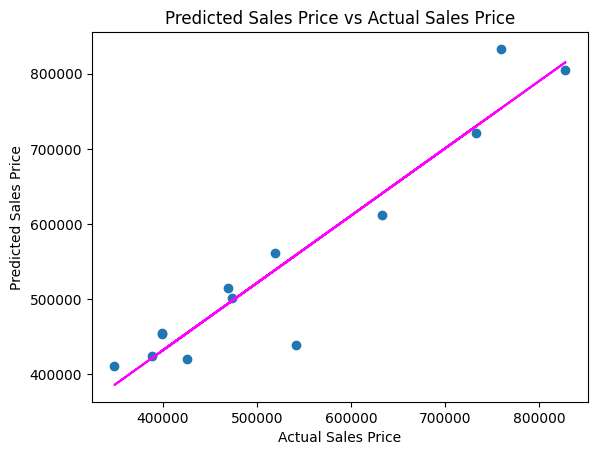

In [395]:
# Clean the data by removing sales data from before 2022 and break into features and labels
cleaned_df = df[df['sales_prices'].apply(lambda x: next(iter(x), None)) >= 2022]
cleaned_df = cleaned_df.dropna(subset=['square_feet', 'most_recent_sales_price'])
X = cleaned_df[['square_feet', 'year_built', 'bedrooms', 'bathrooms', 'has_garage', 'has_apt']].values
y = cleaned_df['most_recent_sales_price'].values

# Split data into training/testing groups and create a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
sales_model = LinearRegression().fit(X_train, y_train)
predictions = sales_model.predict(X_test)

# Determine how well the model predicts
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Sales Price')
plt.ylabel('Predicted Sales Price')
plt.title('Predicted Sales Price vs Actual Sales Price')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Un-comment this section to allow the user to input custom home information to predict

In [396]:
# # Allows user to input square footage to be used in the prediction
# sqft = int(input("Enter a square footage amount (ex. 2050) to predict sales price and market value:"))
# year_built = int(input("Enter a year that the home was built (ex. 2019) to predict sales price and market value:"))
# bedrooms = int(input("Enter the number of bedrooms (ex. 3) to predict sales price and market value:"))
# bathrooms = int(input("Enter the number of bathrooms (ex. 2.5) to predict sales price and market value:"))
# has_garage = int(input("Enter 1 if there is a garage, 0 if not:"))
# has_apt = int(input("Enter 1 if there is a garage apartment, 0 if not:"))

## Predictions

In [397]:
# Predict sales price
# predicted_sales = sales_model.predict([[sqft, year_built, bedrooms, bathrooms, has_garage, has_apt]])[0]
predicted_sales = sales_model.predict([[1700, 2021, 3, 3, 1, 0]])[0]
formatted_sales_price = "${:,.0f}".format(predicted_sales)
print("Predicted Sales Price: ", formatted_sales_price)

# Predict market value
# predicted_market_value = market_model.predict([[sqft, year_built, bedrooms, bathrooms, has_garage, has_apt]])[0]
predicted_market_value = market_model.predict([[1700, 2021, 3, 3, 1, 0]])[0]
formatted_market_value = "${:,.0f}".format(predicted_market_value)
print("Predicted Market Value: ", formatted_market_value)

Predicted Sales Price:  $547,953
Predicted Market Value:  $550,681
